In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
sns.set()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:496: FutureWarning: Passing (type, 1) or 

In [2]:
!pip install yfinance --upgrade --no-cache-dir

Requirement already up-to-date: yfinance in /usr/local/lib/python3.6/dist-packages (0.1.55)


In [3]:
## Save future files to your drive
## In this notebook control for multiple testing
import numpy as np
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
%cd "/content/drive/My Drive/Deep Trading"

Mounted at /content/drive
/content/drive/My Drive/Deep Trading


In [107]:
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
yf.pdr_override()
df_full = pdr.get_data_yahoo("^NSEI", start="2020-01-01").reset_index()
df_full.to_csv('NIFTY50.csv',index=False)
df_full.head()

[*********************100%***********************]  1 of 1 downloaded


,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-01,12202.150391,12222.200195,12165.299805,12182.500000,12182.500000,304100
1,2020-01-02,12198.549805,12289.900391,12195.250000,12282.200195,12282.200195,407700
2,2020-01-03,12261.099609,12265.599609,12191.349609,12226.650391,12226.650391,428800
3,2020-01-06,12170.599609,12179.099609,11974.200195,11993.049805,11993.049805,396500
4,2020-01-07,12079.099609,12152.150391,12005.349609,12052.950195,12052.950195,447800


In [108]:
df_full = pd.read_csv('NIFTY50.csv')



In [109]:
df_full.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-01,12202.150391,12222.200195,12165.299805,12182.500000,12182.500000,304100
1,2020-01-02,12198.549805,12289.900391,12195.250000,12282.200195,12282.200195,407700
2,2020-01-03,12261.099609,12265.599609,12191.349609,12226.650391,12226.650391,428800
3,2020-01-06,12170.599609,12179.099609,11974.200195,11993.049805,11993.049805,396500
4,2020-01-07,12079.099609,12152.150391,12005.349609,12052.950195,12052.950195,447800


## LSTM Recurrent Neural Network

In [110]:
df = df_full.copy()
date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
minmax = MinMaxScaler().fit(df.iloc[:, 1:].astype('float32'))
df_log = minmax.transform(df.iloc[:, 1:].astype('float32'))
df_log = pd.DataFrame(df_log)
df_log.head()

,0,1,2,3,4,5
0,0.951367,0.952590,0.967549,0.962164,0.962164,0.167918
1,0.950600,0.967999,0.973775,0.983144,0.983144,0.225124
2,0.963922,0.962468,0.972964,0.971455,0.971455,0.236775
3,0.944647,0.942780,0.927822,0.922297,0.922297,0.218940
4,0.925160,0.936646,0.934297,0.934902,0.934902,0.247267


In [111]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [12]:
# num_layers = 1
# size_layer = 128
# timestamp = 5
# epoch = 500
# dropout_rate = 0.7
# future_day = 50

In [112]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 200
dropout_rate = 0.9
future_day = 100

In [113]:
try:
  sess.close()
except:
  print('No Interactive Session')

In [114]:
from tensorflow.python.framework import ops
ops.reset_default_graph()
modelnn = Model(0.01, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [115]:
for i in range(epoch):
    init_value = np.zeros((1, num_layers * 2 * size_layer))
    total_loss = 0
    for k in range(0, df_log.shape[0] - 1, timestamp):
        index = min(k + timestamp, df_log.shape[0] -1)
        batch_x = np.expand_dims(
            df_log.iloc[k : index, :].values, axis = 0
        )
        batch_y = df_log.iloc[k + 1 : index + 1, :].values
        last_state, _, loss = sess.run(
            [modelnn.last_state, modelnn.optimizer, modelnn.cost],
            feed_dict = {
                modelnn.X: batch_x,
                modelnn.Y: batch_y,
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        total_loss += loss
    total_loss /= df_log.shape[0] // timestamp
    if (i + 1) % 100 == 0:
        print('epoch:', i + 1, 'avg loss:', total_loss)

epoch: 100 avg loss: 0.004008920532041451
epoch: 200 avg loss: 0.0035226055846405437


In [116]:
output_predict = np.zeros((df_log.shape[0] + future_day, df_log.shape[1]))
output_predict[0] = df_log.iloc[0]
upper_b = (df_log.shape[0] // timestamp) * timestamp
init_value = np.zeros((1, num_layers * 2 * size_layer))
for k in range(0, (df_log.shape[0] // timestamp) * timestamp, timestamp):
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(
                df_log.iloc[k : k + timestamp], axis = 0
            ),
            modelnn.hidden_layer: init_value,
        },
    )
    init_value = last_state
    output_predict[k + 1 : k + timestamp + 1] = out_logits

out_logits, last_state = sess.run(
    [modelnn.logits, modelnn.last_state],
    feed_dict = {
        modelnn.X: np.expand_dims(df_log.iloc[upper_b:], axis = 0),
        modelnn.hidden_layer: init_value,
    },
)
init_value = last_state
output_predict[upper_b + 1 : df_log.shape[0] + 1] = out_logits
df_log.loc[df_log.shape[0]] = out_logits[-1]
date_ori.append(date_ori[-1] + timedelta(days = 1))

In [117]:
for i in range(future_day - 1):
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(df_log.iloc[-timestamp:], axis = 0),
            modelnn.hidden_layer: init_value,
        },
    )
    init_value = last_state
    output_predict[df_log.shape[0]] = out_logits[-1]
    df_log.loc[df_log.shape[0]] = out_logits[-1]
    date_ori.append(date_ori[-1] + timedelta(days = 1))

In [118]:
df_log = minmax.inverse_transform(output_predict)
date_ori = pd.Series(date_ori).dt.strftime(date_format = '%Y-%m-%d').tolist()

In [119]:
def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

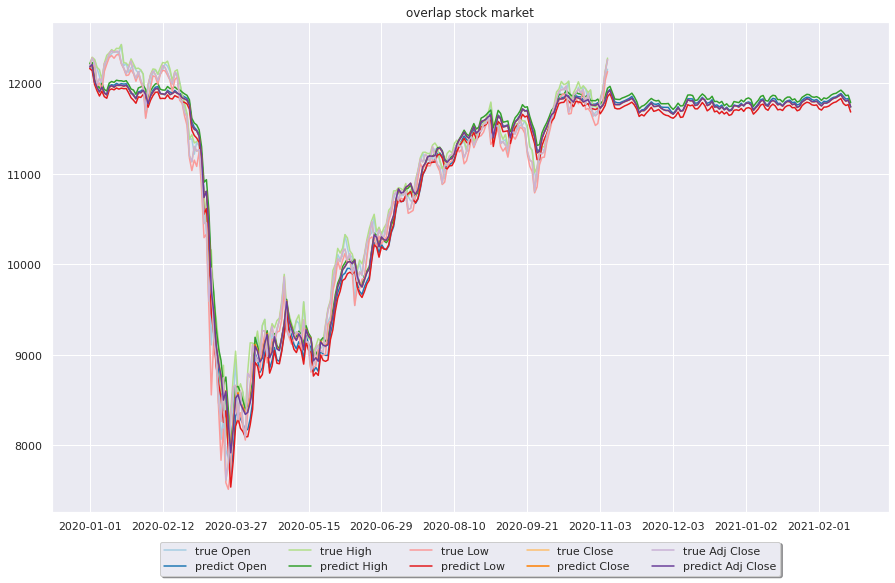

In [121]:
current_palette = sns.color_palette('Paired', 12)
fig = plt.figure(figsize = (15, 10))
ax = plt.subplot(111)
x_range_original = np.arange(df.shape[0])
x_range_future = np.arange(df_log.shape[0])
ax.plot(
    x_range_original,
    df.iloc[:, 1],
    label = 'true Open',
    color = current_palette[0],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 0], 0.5),
    label = 'predict Open',
    color = current_palette[1],
)
ax.plot(
    x_range_original,
    df.iloc[:, 2],
    label = 'true High',
    color = current_palette[2],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 1], 0.5),
    label = 'predict High',
    color = current_palette[3],
)
ax.plot(
    x_range_original,
    df.iloc[:, 3],
    label = 'true Low',
    color = current_palette[4],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 2], 0.5),
    label = 'predict Low',
    color = current_palette[5],
)
ax.plot(
    x_range_original,
    df.iloc[:, 4],
    label = 'true Close',
    color = current_palette[6],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 3], 0.5),
    label = 'predict Close',
    color = current_palette[7],
)
ax.plot(
    x_range_original,
    df.iloc[:, 5],
    label = 'true Adj Close',
    color = current_palette[8],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 4], 0.5),
    label = 'predict Adj Close',
    color = current_palette[9],
)
box = ax.get_position()
ax.set_position(
    [box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9]
)
ax.legend(
    loc = 'upper center',
    bbox_to_anchor = (0.5, -0.05),
    fancybox = True,
    shadow = True,
    ncol = 5,
)
plt.title('overlap stock market')
plt.xticks(x_range_future[::30], date_ori[::30])
plt.style.use('dark_background')
plt.show()

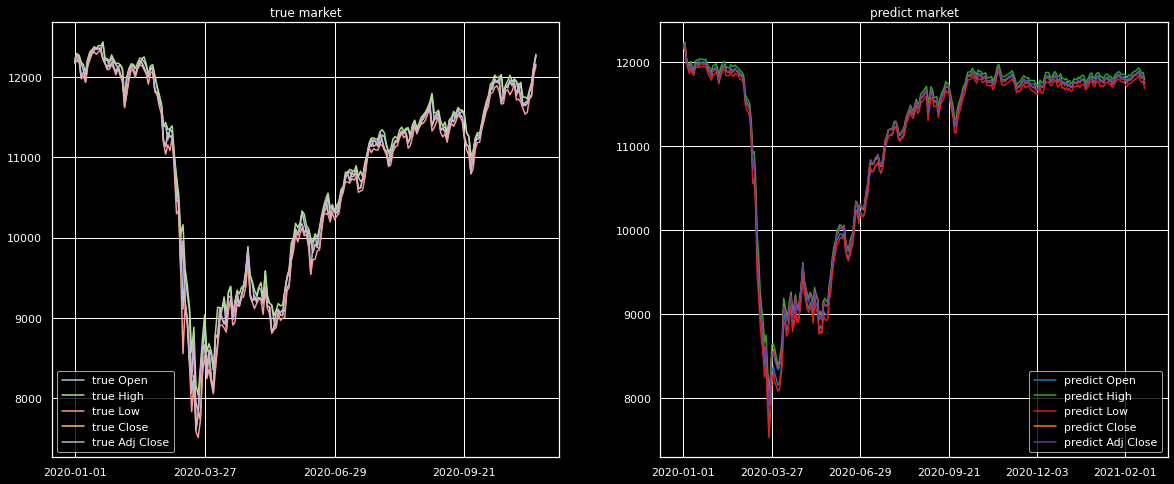

In [122]:
fig = plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
plt.plot(
    x_range_original,
    df.iloc[:, 1],
    label = 'true Open',
    color = current_palette[0],
)
plt.plot(
    x_range_original,
    df.iloc[:, 2],
    label = 'true High',
    color = current_palette[2],
)
plt.plot(
    x_range_original,
    df.iloc[:, 3],
    label = 'true Low',
    color = current_palette[4],
)
plt.plot(
    x_range_original,
    df.iloc[:, 4],
    label = 'true Close',
    color = current_palette[6],
)
plt.plot(
    x_range_original,
    df.iloc[:, 5],
    label = 'true Adj Close',
    color = current_palette[8],
)
plt.xticks(x_range_original[::60], df.iloc[:, 0].tolist()[::60])
plt.legend()
plt.title('true market')
plt.subplot(1, 2, 2)
plt.plot(
    x_range_future,
    anchor(df_log[:, 0], 0.5),
    label = 'predict Open',
    color = current_palette[1],
)
plt.plot(
    x_range_future,
    anchor(df_log[:, 1], 0.5),
    label = 'predict High',
    color = current_palette[3],
)
plt.plot(
    x_range_future,
    anchor(df_log[:, 2], 0.5),
    label = 'predict Low',
    color = current_palette[5],
)
plt.plot(
    x_range_future,
    anchor(df_log[:, 3], 0.5),
    label = 'predict Close',
    color = current_palette[7],
)
plt.plot(
    x_range_future,
    anchor(df_log[:, 4], 0.5),
    label = 'predict Adj Close',
    color = current_palette[9],
)
plt.xticks(x_range_future[::60], date_ori[::60])
plt.legend()
plt.title('predict market')
plt.show()

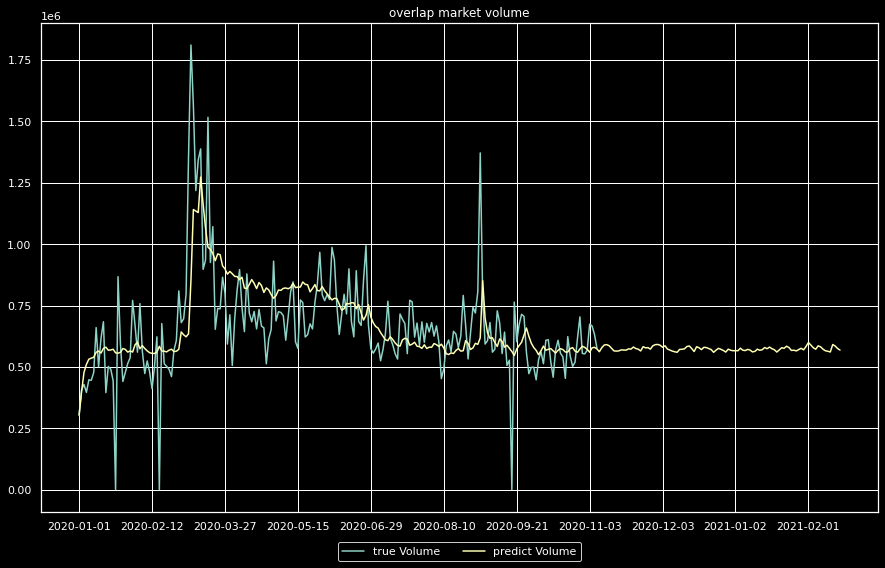

In [123]:
fig = plt.figure(figsize = (15, 10))
ax = plt.subplot(111)
ax.plot(x_range_original, df.iloc[:, -1], label = 'true Volume')
ax.plot(x_range_future, anchor(df_log[:, -1], 0.5), label = 'predict Volume')
box = ax.get_position()
ax.set_position(
    [box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9]
)
ax.legend(
    loc = 'upper center',
    bbox_to_anchor = (0.5, -0.05),
    fancybox = True,
    shadow = True,
    ncol = 5,
)
plt.xticks(x_range_future[::30], date_ori[::30])
plt.title('overlap market volume')
plt.show()

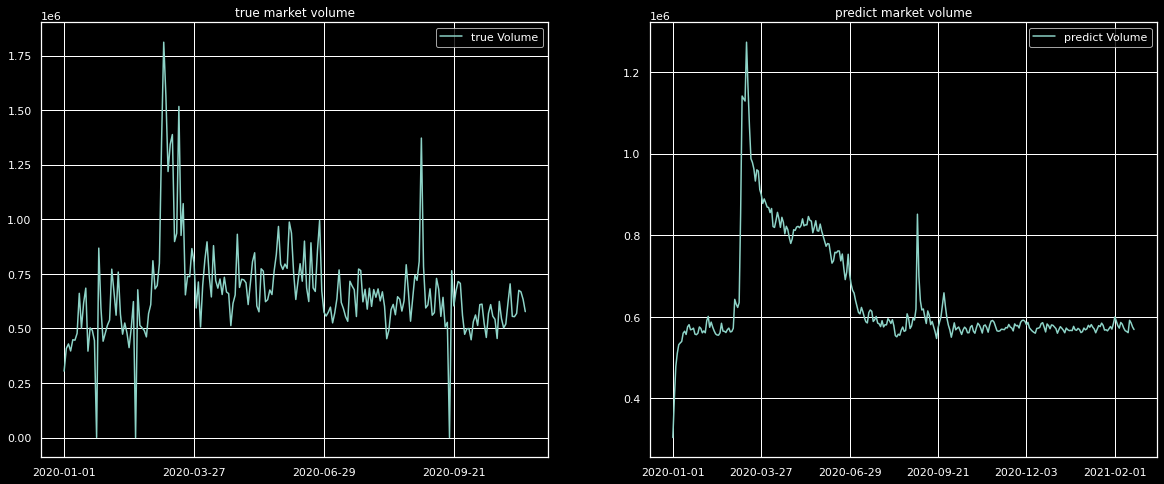

In [124]:
fig = plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
plt.plot(x_range_original, df.iloc[:, -1], label = 'true Volume')
plt.xticks(x_range_original[::60], df.iloc[:, 0].tolist()[::60])
plt.legend()
plt.title('true market volume')
plt.subplot(1, 2, 2)
plt.plot(x_range_future, anchor(df_log[:, -1], 0.5), label = 'predict Volume')
plt.xticks(x_range_future[::60], date_ori[::60])
plt.legend()
plt.title('predict market volume')
plt.show()

## Encoder-Decoder Feed-forward + LSTM Recurrent Neural Network

In [125]:
import time

df = df_full.copy()
date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
minmax = MinMaxScaler().fit(df.iloc[:, 1:].astype('float32'))
df_log = minmax.transform(df.iloc[:, 1:].astype('float32'))
df_log = pd.DataFrame(df_log)
df_log.head()

,0,1,2,3,4,5
0,0.951367,0.952590,0.967549,0.962164,0.962164,0.167918
1,0.950600,0.967999,0.973775,0.983144,0.983144,0.225124
2,0.963922,0.962468,0.972964,0.971455,0.971455,0.236775
3,0.944647,0.942780,0.927822,0.922297,0.922297,0.218940
4,0.925160,0.936646,0.934297,0.934902,0.934902,0.247267


In [126]:
def reducedimension(
    input_, dimension = 2, learning_rate = 0.001, hidden_layer = 256, epoch = 20
):

    input_size = input_.shape[1]
    X = tf.placeholder('float', [None, input_size])
    first_layer_encoder = tf.layers.dense(
        X, hidden_layer, activation = tf.nn.sigmoid
    )
    second_layer_encoder = tf.layers.dense(
        first_layer_encoder, dimension, activation = tf.nn.sigmoid
    )
    first_layer_decoder = tf.layers.dense(
        second_layer_encoder, hidden_layer, activation = tf.nn.sigmoid
    )
    second_layer_decoder = tf.layers.dense(
        first_layer_decoder, input_size, activation = tf.nn.sigmoid
    )
    cost = tf.reduce_mean(tf.square(X - second_layer_decoder))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())

    for i in range(epoch):
        last_time = time.time()
        _, loss = sess.run([optimizer, cost], feed_dict = {X: input_})
        if (i + 1) % 10 == 0:
            print(
                'epoch:', i + 1, 'loss:', loss, 'time:', time.time() - last_time
            )

    vectors = sess.run(second_layer_encoder, feed_dict = {X: input_})
    tf.reset_default_graph()
    return vectors

You can try to reduce dimensions if you more features like sentiment value, sentiment spike and etc

In [127]:
thought_vector = reducedimension(
    df_log.values,
    dimension = 16,
    learning_rate = 0.001,
    hidden_layer = 128,
    epoch = 100,
)

epoch: 10 loss: 0.09608064 time: 0.0017998218536376953
epoch: 20 loss: 0.09560071 time: 0.0015037059783935547
epoch: 30 loss: 0.09512471 time: 0.0016074180603027344
epoch: 40 loss: 0.094652615 time: 0.0015811920166015625
epoch: 50 loss: 0.094184466 time: 0.0016210079193115234
epoch: 60 loss: 0.093720295 time: 0.0015532970428466797
epoch: 70 loss: 0.09326012 time: 0.0015289783477783203
epoch: 80 loss: 0.092803895 time: 0.0015861988067626953
epoch: 90 loss: 0.092351735 time: 0.0016207695007324219
epoch: 100 loss: 0.091903545 time: 0.0015587806701660156


In [128]:
thought_vector

array([[0.74342114, 0.7126899 , 0.66188455, ..., 0.5704527 , 0.22202116,
        0.35040492],
       [0.743136  , 0.7128999 , 0.66180664, ..., 0.5698994 , 0.22222702,
        0.35122034],
       [0.742924  , 0.7133617 , 0.66190296, ..., 0.56992954, 0.22212695,
        0.35097775],
       ...,
       [0.7420135 , 0.7155866 , 0.6628278 , ..., 0.57022023, 0.22436377,
        0.35097334],
       [0.7421702 , 0.7147592 , 0.66235805, ..., 0.5696326 , 0.22331333,
        0.35148886],
       [0.7424773 , 0.713974  , 0.6620074 , ..., 0.5694725 , 0.22279513,
        0.3517958 ]], dtype=float32)

In [129]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [130]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 500
dropout_rate = 0.1

In [131]:
tf.reset_default_graph()
modelnn = Model(0.001, num_layers, thought_vector.shape[1], size_layer, df_log.shape[1], dropout_rate)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [132]:
for i in range(epoch):
    init_value = np.zeros((1, num_layers * 2 * size_layer))
    total_loss = 0
    for k in range(0, thought_vector.shape[0] - 1, timestamp):
        index = min(k + timestamp, thought_vector.shape[0] -1)
        batch_x = np.expand_dims(
            thought_vector[k : index, :], axis = 0
        )
        batch_y = df_log.iloc[k + 1 : index + 1, :].values
        last_state, _, loss = sess.run(
            [modelnn.last_state, modelnn.optimizer, modelnn.cost],
            feed_dict = {
                modelnn.X: batch_x,
                modelnn.Y: batch_y,
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        total_loss += loss
    total_loss /= df_log.shape[0] // timestamp
    if (i + 1) % 100 == 0:
        print('epoch:', i + 1, 'avg loss:', total_loss)

epoch: 100 avg loss: 0.06302188874854307
epoch: 200 avg loss: 0.05924400944648022
epoch: 300 avg loss: 0.05871449220423875
epoch: 400 avg loss: 0.05862327147804622
epoch: 500 avg loss: 0.058617888452274544


In [133]:
output_predict = np.zeros((df_log.shape[0] + 1, df_log.shape[1]))
output_predict[0, :] = df_log.iloc[0, :]
upper_b = (df_log.shape[0] // timestamp) * timestamp
init_value = np.zeros((1, num_layers * 2 * size_layer))
for k in range(0, (df_log.shape[0] // timestamp) * timestamp, timestamp):
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(
                thought_vector[k : k + timestamp, :], axis = 0
            ),
            modelnn.hidden_layer: init_value,
        },
    )
    init_value = last_state
    output_predict[k + 1 : k + timestamp + 1] = out_logits

out_logits, last_state = sess.run(
    [modelnn.logits, modelnn.last_state],
    feed_dict = {
        modelnn.X: np.expand_dims(thought_vector[upper_b:], axis = 0),
        modelnn.hidden_layer: init_value,
    },
)
init_value = last_state
output_predict[upper_b + 1 : df_log.shape[0] + 1] = out_logits
df_log.loc[df_log.shape[0]] = out_logits[-1]
date_ori.append(date_ori[-1] + timedelta(days = 1))

In [134]:
df_log = minmax.inverse_transform(output_predict)
date_ori = pd.Series(date_ori).dt.strftime(date_format = '%Y-%m-%d').tolist()

In [135]:
def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

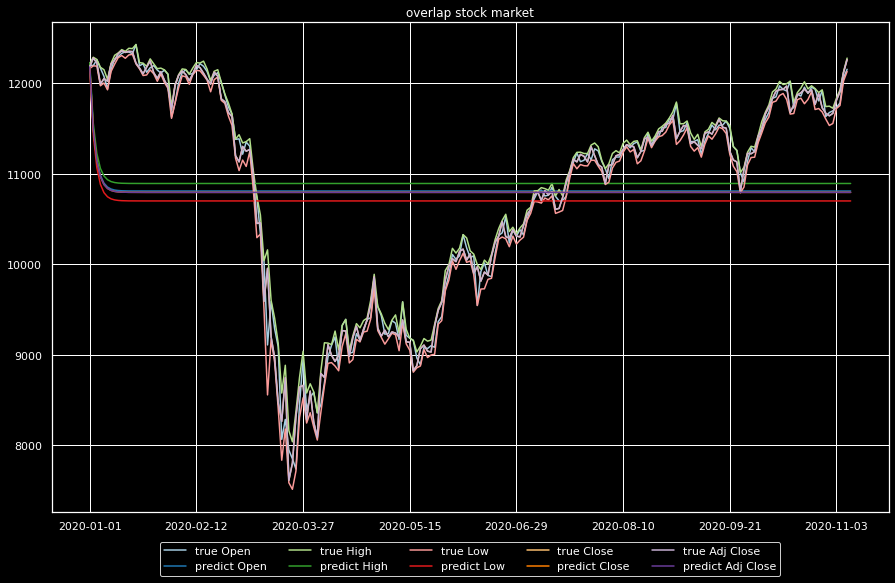

In [136]:
current_palette = sns.color_palette('Paired', 12)
fig = plt.figure(figsize = (15, 10))
ax = plt.subplot(111)
x_range_original = np.arange(df.shape[0])
x_range_future = np.arange(df_log.shape[0])
ax.plot(
    x_range_original,
    df.iloc[:, 1],
    label = 'true Open',
    color = current_palette[0],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 0], 0.5),
    label = 'predict Open',
    color = current_palette[1],
)
ax.plot(
    x_range_original,
    df.iloc[:, 2],
    label = 'true High',
    color = current_palette[2],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 1], 0.5),
    label = 'predict High',
    color = current_palette[3],
)
ax.plot(
    x_range_original,
    df.iloc[:, 3],
    label = 'true Low',
    color = current_palette[4],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 2], 0.5),
    label = 'predict Low',
    color = current_palette[5],
)
ax.plot(
    x_range_original,
    df.iloc[:, 4],
    label = 'true Close',
    color = current_palette[6],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 3], 0.5),
    label = 'predict Close',
    color = current_palette[7],
)
ax.plot(
    x_range_original,
    df.iloc[:, 5],
    label = 'true Adj Close',
    color = current_palette[8],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 4], 0.5),
    label = 'predict Adj Close',
    color = current_palette[9],
)
box = ax.get_position()
ax.set_position(
    [box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9]
)
ax.legend(
    loc = 'upper center',
    bbox_to_anchor = (0.5, -0.05),
    fancybox = True,
    shadow = True,
    ncol = 5,
)
plt.title('overlap stock market')
plt.xticks(x_range_future[::30], date_ori[::30])
plt.show()

## LSTM Bidirectional Neural Network

In [137]:
df = df_full.copy()
date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
minmax = MinMaxScaler().fit(df.iloc[:, 1:].astype('float32'))
df_log = minmax.transform(df.iloc[:, 1:].astype('float32'))
df_log = pd.DataFrame(df_log)
df_log.head()

,0,1,2,3,4,5
0,0.951367,0.952590,0.967549,0.962164,0.962164,0.167918
1,0.950600,0.967999,0.973775,0.983144,0.983144,0.225124
2,0.963922,0.962468,0.972964,0.971455,0.971455,0.236775
3,0.944647,0.942780,0.927822,0.922297,0.922297,0.218940
4,0.925160,0.936646,0.934297,0.934902,0.934902,0.247267


In [138]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        backward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        forward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop_backward = tf.contrib.rnn.DropoutWrapper(
            backward_rnn_cells, output_keep_prob = forget_bias
        )
        forward_backward = tf.contrib.rnn.DropoutWrapper(
            forward_rnn_cells, output_keep_prob = forget_bias
        )
        self.backward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * 2 * size_layer)
        )
        self.forward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.nn.bidirectional_dynamic_rnn(
            forward_backward,
            drop_backward,
            self.X,
            initial_state_fw = self.forward_hidden_layer,
            initial_state_bw = self.backward_hidden_layer,
            dtype = tf.float32,
        )
        self.outputs = tf.concat(self.outputs, 2)
        rnn_W = tf.Variable(tf.random_normal((size_layer * 2, output_size)))
        rnn_B = tf.Variable(tf.random_normal([output_size]))
        self.logits = tf.matmul(self.outputs[-1], rnn_W) + rnn_B
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )


In [139]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 200
dropout_rate = 0.9
future_day = 50

In [140]:
tf.reset_default_graph()
modelnn = Model(0.01, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [141]:
for i in range(epoch):
    init_value_forward = np.zeros((1, num_layers * 2 * size_layer))
    init_value_backward = np.zeros((1, num_layers * 2 * size_layer))
    total_loss = 0
    for k in range(0, df_log.shape[0] - 1, timestamp):
        index = min(k + timestamp, df_log.shape[0] - 1)
        batch_x = np.expand_dims(
            df_log.iloc[k : index, :].values, axis = 0
        )
        batch_y = df_log.iloc[k + 1 : index + 1, :].values
        last_state, _, loss = sess.run(
            [modelnn.last_state, modelnn.optimizer, modelnn.cost],
            feed_dict = {
                modelnn.X: batch_x,
                modelnn.Y: batch_y,
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        total_loss += loss
    total_loss /= df_log.shape[0] // timestamp
    if (i + 1) % 100 == 0:
        print('epoch:', i + 1, 'avg loss:', total_loss)


epoch: 100 avg loss: 0.016972624258847817
epoch: 200 avg loss: 0.006793170773778998


In [142]:
output_predict = np.zeros((df_log.shape[0] + future_day, df_log.shape[1]))
output_predict[0, :] = df_log.iloc[0, :]
upper_b = (df_log.shape[0] // timestamp) * timestamp
init_value_forward = np.zeros((1, num_layers * 2 * size_layer))
init_value_backward = np.zeros((1, num_layers * 2 * size_layer))
for k in range(0, (df_log.shape[0] // timestamp) * timestamp, timestamp):
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(
                df_log.iloc[k : k + timestamp, :], axis = 0
            ),
            modelnn.backward_hidden_layer: init_value_backward,
            modelnn.forward_hidden_layer: init_value_forward,
        },
    )
    init_value_forward = last_state[0]
    init_value_backward = last_state[1]
    output_predict[k + 1 : k + timestamp + 1, :] = out_logits

out_logits, last_state = sess.run(
    [modelnn.logits, modelnn.last_state],
    feed_dict = {
        modelnn.X: np.expand_dims(df_log.iloc[upper_b:, :], axis = 0),
        modelnn.backward_hidden_layer: init_value_backward,
        modelnn.forward_hidden_layer: init_value_forward,
    },
)
init_value_forward = last_state[0]
init_value_backward = last_state[1]
output_predict[upper_b + 1 : df_log.shape[0] + 1, :] = out_logits
df_log.loc[df_log.shape[0]] = out_logits[-1, :]
date_ori.append(date_ori[-1] + timedelta(days = 1))


In [143]:
for i in range(future_day - 1):
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(df_log.iloc[-timestamp:, :], axis = 0),
            modelnn.backward_hidden_layer: init_value_backward,
            modelnn.forward_hidden_layer: init_value_forward,
        },
    )
    init_value_forward = last_state[0]
    init_value_backward = last_state[1]
    output_predict[df_log.shape[0], :] = out_logits[-1, :]
    df_log.loc[df_log.shape[0]] = out_logits[-1, :]
    date_ori.append(date_ori[-1] + timedelta(days = 1))

In [144]:
df_log = minmax.inverse_transform(output_predict)
date_ori = pd.Series(date_ori).dt.strftime(date_format = '%Y-%m-%d').tolist()

In [145]:
def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

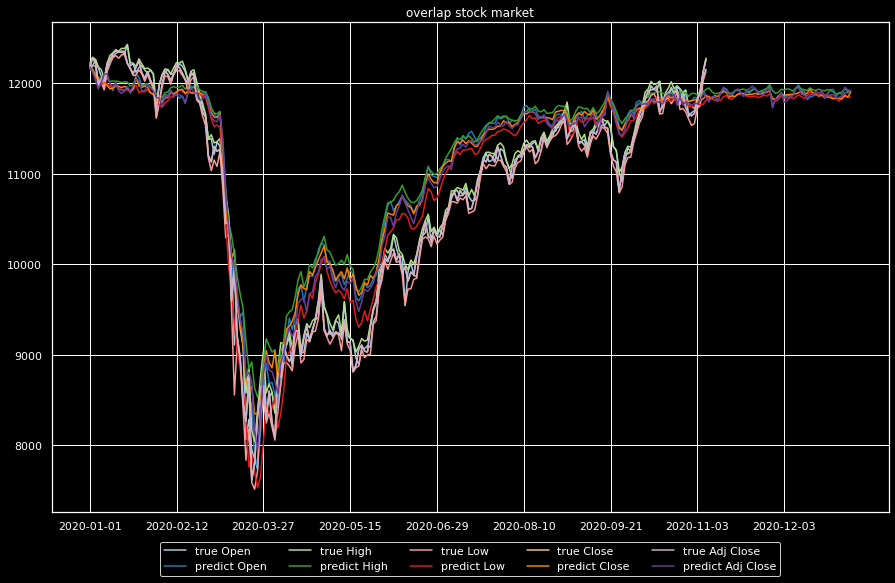

In [146]:
current_palette = sns.color_palette('Paired', 12)
fig = plt.figure(figsize = (15, 10))
ax = plt.subplot(111)
x_range_original = np.arange(df.shape[0])
x_range_future = np.arange(df_log.shape[0])
ax.plot(
    x_range_original,
    df.iloc[:, 1],
    label = 'true Open',
    color = current_palette[0],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 0], 0.5),
    label = 'predict Open',
    color = current_palette[1],
)
ax.plot(
    x_range_original,
    df.iloc[:, 2],
    label = 'true High',
    color = current_palette[2],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 1], 0.5),
    label = 'predict High',
    color = current_palette[3],
)
ax.plot(
    x_range_original,
    df.iloc[:, 3],
    label = 'true Low',
    color = current_palette[4],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 2], 0.5),
    label = 'predict Low',
    color = current_palette[5],
)
ax.plot(
    x_range_original,
    df.iloc[:, 4],
    label = 'true Close',
    color = current_palette[6],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 3], 0.5),
    label = 'predict Close',
    color = current_palette[7],
)
ax.plot(
    x_range_original,
    df.iloc[:, 5],
    label = 'true Adj Close',
    color = current_palette[8],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 4], 0.5),
    label = 'predict Adj Close',
    color = current_palette[9],
)
box = ax.get_position()
ax.set_position(
    [box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9]
)
ax.legend(
    loc = 'upper center',
    bbox_to_anchor = (0.5, -0.05),
    fancybox = True,
    shadow = True,
    ncol = 5,
)
plt.title('overlap stock market')
plt.xticks(x_range_future[::30], date_ori[::30])
plt.show()

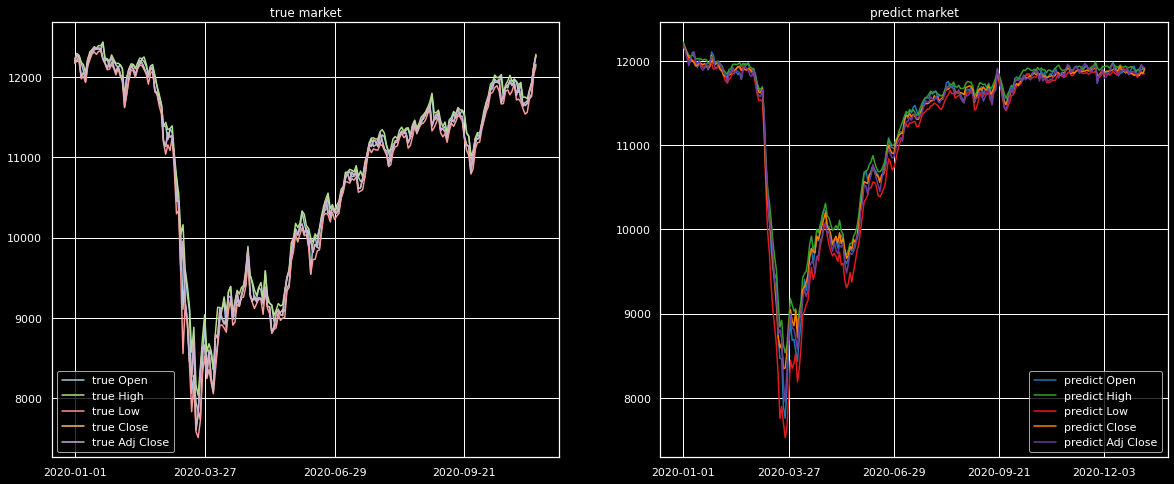

In [147]:
fig = plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
plt.plot(
    x_range_original,
    df.iloc[:, 1],
    label = 'true Open',
    color = current_palette[0],
)
plt.plot(
    x_range_original,
    df.iloc[:, 2],
    label = 'true High',
    color = current_palette[2],
)
plt.plot(
    x_range_original,
    df.iloc[:, 3],
    label = 'true Low',
    color = current_palette[4],
)
plt.plot(
    x_range_original,
    df.iloc[:, 4],
    label = 'true Close',
    color = current_palette[6],
)
plt.plot(
    x_range_original,
    df.iloc[:, 5],
    label = 'true Adj Close',
    color = current_palette[8],
)
plt.xticks(x_range_original[::60], df.iloc[:, 0].tolist()[::60])
plt.legend()
plt.title('true market')
plt.subplot(1, 2, 2)
plt.plot(
    x_range_future,
    anchor(df_log[:, 0], 0.5),
    label = 'predict Open',
    color = current_palette[1],
)
plt.plot(
    x_range_future,
    anchor(df_log[:, 1], 0.5),
    label = 'predict High',
    color = current_palette[3],
)
plt.plot(
    x_range_future,
    anchor(df_log[:, 2], 0.5),
    label = 'predict Low',
    color = current_palette[5],
)
plt.plot(
    x_range_future,
    anchor(df_log[:, 3], 0.5),
    label = 'predict Close',
    color = current_palette[7],
)
plt.plot(
    x_range_future,
    anchor(df_log[:, 4], 0.5),
    label = 'predict Adj Close',
    color = current_palette[9],
)
plt.xticks(x_range_future[::60], date_ori[::60])
plt.legend()
plt.title('predict market')
plt.show()

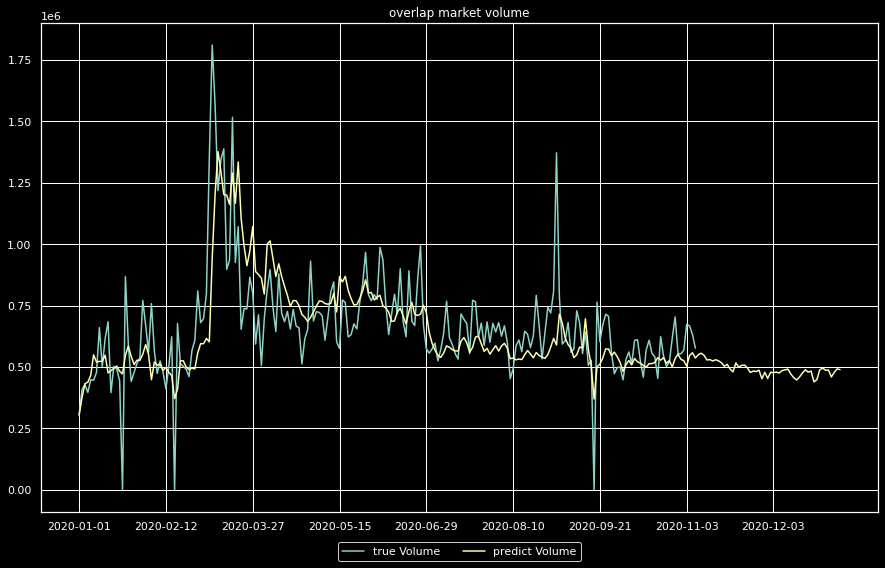

In [148]:
fig = plt.figure(figsize = (15, 10))
ax = plt.subplot(111)
ax.plot(x_range_original, df.iloc[:, -1], label = 'true Volume')
ax.plot(x_range_future, anchor(df_log[:, -1], 0.5), label = 'predict Volume')
box = ax.get_position()
ax.set_position(
    [box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9]
)
ax.legend(
    loc = 'upper center',
    bbox_to_anchor = (0.5, -0.05),
    fancybox = True,
    shadow = True,
    ncol = 5,
)
plt.xticks(x_range_future[::30], date_ori[::30])
plt.title('overlap market volume')
plt.show()

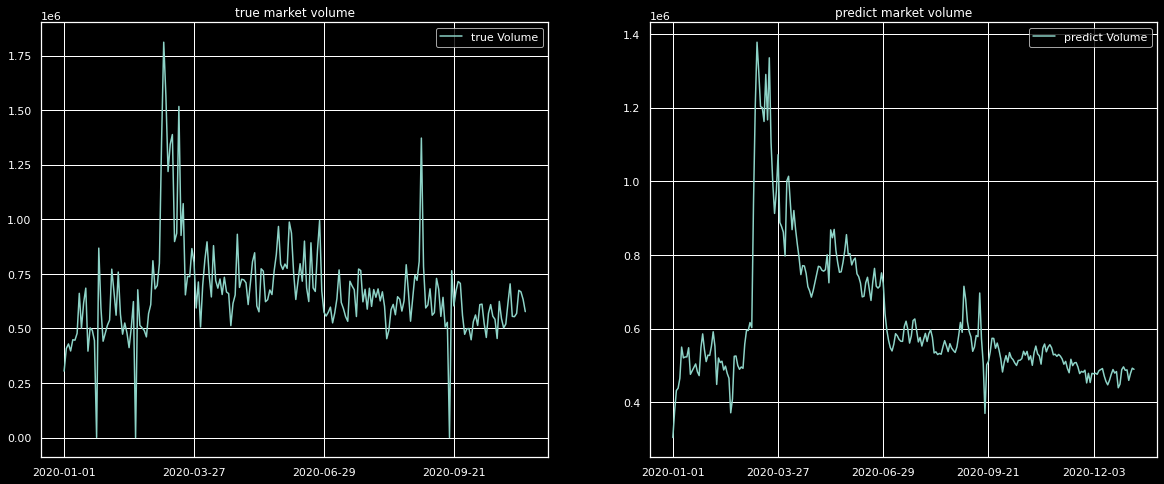

In [149]:
fig = plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
plt.plot(x_range_original, df.iloc[:, -1], label = 'true Volume')
plt.xticks(x_range_original[::60], df.iloc[:, 0].tolist()[::60])
plt.legend()
plt.title('true market volume')
plt.subplot(1, 2, 2)
plt.plot(x_range_future, anchor(df_log[:, -1], 0.5), label = 'predict Volume')
plt.xticks(x_range_future[::60], date_ori[::60])
plt.legend()
plt.title('predict market volume')
plt.show()

## 2-Path LSTM Recurrent Neural Network

In [150]:
df = df_full.copy()
date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
minmax = MinMaxScaler().fit(df.iloc[:, 1:].astype('float32'))
df_log = minmax.transform(df.iloc[:, 1:].astype('float32'))
df_log = pd.DataFrame(df_log)
df_log.head()

,0,1,2,3,4,5
0,0.951367,0.952590,0.967549,0.962164,0.962164,0.167918
1,0.950600,0.967999,0.973775,0.983144,0.983144,0.225124
2,0.963922,0.962468,0.972964,0.971455,0.971455,0.236775
3,0.944647,0.942780,0.927822,0.922297,0.922297,0.218940
4,0.925160,0.936646,0.934297,0.934902,0.934902,0.247267


In [151]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 200
dropout_rate = 0.9
future_day = 50

In [152]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        with tf.variable_scope('forward', reuse = False):
            rnn_cells_forward = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)],
                state_is_tuple = False,
            )
            self.X_forward = tf.placeholder(tf.float32, (None, None, size))
            drop_forward = tf.contrib.rnn.DropoutWrapper(
                rnn_cells_forward, output_keep_prob = forget_bias
            )
            self.hidden_layer_forward = tf.placeholder(
                tf.float32, (None, num_layers * 2 * size_layer)
            )
            self.outputs_forward, self.last_state_forward = tf.nn.dynamic_rnn(
                drop_forward,
                self.X_forward,
                initial_state = self.hidden_layer_forward,
                dtype = tf.float32,
            )

        with tf.variable_scope('backward', reuse = False):
            rnn_cells_backward = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)],
                state_is_tuple = False,
            )
            self.X_backward = tf.placeholder(tf.float32, (None, None, size))
            drop_backward = tf.contrib.rnn.DropoutWrapper(
                rnn_cells_backward, output_keep_prob = forget_bias
            )
            self.hidden_layer_backward = tf.placeholder(
                tf.float32, (None, num_layers * 2 * size_layer)
            )
            self.outputs_backward, self.last_state_backward = tf.nn.dynamic_rnn(
                drop_backward,
                self.X_backward,
                initial_state = self.hidden_layer_backward,
                dtype = tf.float32,
            )

        self.outputs = self.outputs_backward - self.outputs_forward
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        rnn_W = tf.Variable(tf.random_normal((size_layer, output_size)))
        rnn_B = tf.Variable(tf.random_normal([output_size]))
        self.logits = tf.matmul(self.outputs[-1], rnn_W) + rnn_B
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [153]:
tf.reset_default_graph()
modelnn = Model(
    0.01, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [154]:
for i in range(epoch):
    init_value_forward = np.zeros((1, num_layers * 2 * size_layer))
    init_value_backward = np.zeros((1, num_layers * 2 * size_layer))
    total_loss = 0
    for k in range(0, df_log.shape[0] - 1, timestamp):
        index = min(k + timestamp, df_log.shape[0] - 1)
        batch_x_forward = np.expand_dims(
            df_log.iloc[k:index, :].values, axis = 0
        )
        batch_x_backward = np.expand_dims(
            np.flip(df_log.iloc[k:index, :].values, axis = 0), axis = 0
        )
        batch_y = df_log.iloc[k + 1 : index + 1, :].values
        last_state_forward, last_state_backward, _, loss = sess.run(
            [
                modelnn.last_state_forward,
                modelnn.last_state_backward,
                modelnn.optimizer,
                modelnn.cost,
            ],
            feed_dict = {
                modelnn.X_forward: batch_x_forward,
                modelnn.X_backward: batch_x_backward,
                modelnn.Y: batch_y,
                modelnn.hidden_layer_forward: init_value_forward,
                modelnn.hidden_layer_backward: init_value_backward,
            },
        )
        init_value_forward = last_state_forward
        init_value_backward = last_state_backward
        total_loss += loss
    total_loss /= df_log.shape[0] // timestamp
    if (i + 1) % 100 == 0:
        print('epoch:', i + 1, 'avg loss:', total_loss)

epoch: 100 avg loss: 0.006414561887227353
epoch: 200 avg loss: 0.005931911779390205


In [155]:
output_predict = np.zeros((df_log.shape[0] + future_day, df_log.shape[1]))
output_predict[0, :] = df_log.iloc[0, :]
upper_b = (df_log.shape[0] // timestamp) * timestamp
init_value_forward = np.zeros((1, num_layers * 2 * size_layer))
init_value_backward = np.zeros((1, num_layers * 2 * size_layer))
for k in range(0, (df_log.shape[0] // timestamp) * timestamp, timestamp):
    batch_x_forward = np.expand_dims(
        df_log.iloc[k : k + timestamp, :], axis = 0
    )
    batch_x_backward = np.expand_dims(
        np.flip(df_log.iloc[k : k + timestamp, :].values, axis = 0), axis = 0
    )
    out_logits, last_state_forward, last_state_backward = sess.run(
        [
            modelnn.logits,
            modelnn.last_state_forward,
            modelnn.last_state_backward,
        ],
        feed_dict = {
            modelnn.X_forward: batch_x_forward,
            modelnn.X_backward: batch_x_backward,
            modelnn.hidden_layer_forward: init_value_forward,
            modelnn.hidden_layer_backward: init_value_backward,
        },
    )
    init_value_forward = last_state_forward
    init_value_backward = last_state_backward
    output_predict[k + 1 : k + timestamp + 1, :] = out_logits

batch_x_forward = np.expand_dims(df_log.iloc[upper_b:, :], axis = 0)
batch_x_backward = np.expand_dims(
    np.flip(df_log.iloc[upper_b:, :].values, axis = 0), axis = 0
)
out_logits, last_state_forward, last_state_backward = sess.run(
    [modelnn.logits, modelnn.last_state_forward, modelnn.last_state_backward],
    feed_dict = {
        modelnn.X_forward: batch_x_forward,
        modelnn.X_backward: batch_x_backward,
        modelnn.hidden_layer_forward: init_value_forward,
        modelnn.hidden_layer_backward: init_value_backward,
    },
)
init_value_forward = last_state_forward
init_value_backward = last_state_backward
output_predict[upper_b + 1 : df_log.shape[0] + 1, :] = out_logits
df_log.loc[df_log.shape[0]] = out_logits[-1, :]
date_ori.append(date_ori[-1] + timedelta(days = 1))

In [156]:
for i in range(future_day - 1):
    batch_x_forward = np.expand_dims(df_log.iloc[-timestamp:, :], axis = 0)
    batch_x_backward = np.expand_dims(
        np.flip(df_log.iloc[-timestamp:, :].values, axis = 0), axis = 0
    )
    out_logits, last_state_forward, last_state_backward = sess.run(
        [
            modelnn.logits,
            modelnn.last_state_forward,
            modelnn.last_state_backward,
        ],
        feed_dict = {
            modelnn.X_forward: batch_x_forward,
            modelnn.X_backward: batch_x_backward,
            modelnn.hidden_layer_forward: init_value_forward,
            modelnn.hidden_layer_backward: init_value_backward,
        },
    )
    init_value_forward = last_state_forward
    init_value_backward = last_state_backward
    output_predict[df_log.shape[0], :] = out_logits[-1, :]
    df_log.loc[df_log.shape[0]] = out_logits[-1, :]
    date_ori.append(date_ori[-1] + timedelta(days = 1))


In [157]:
df_log = minmax.inverse_transform(output_predict)
date_ori = pd.Series(date_ori).dt.strftime(date_format = '%Y-%m-%d').tolist()

In [158]:
def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

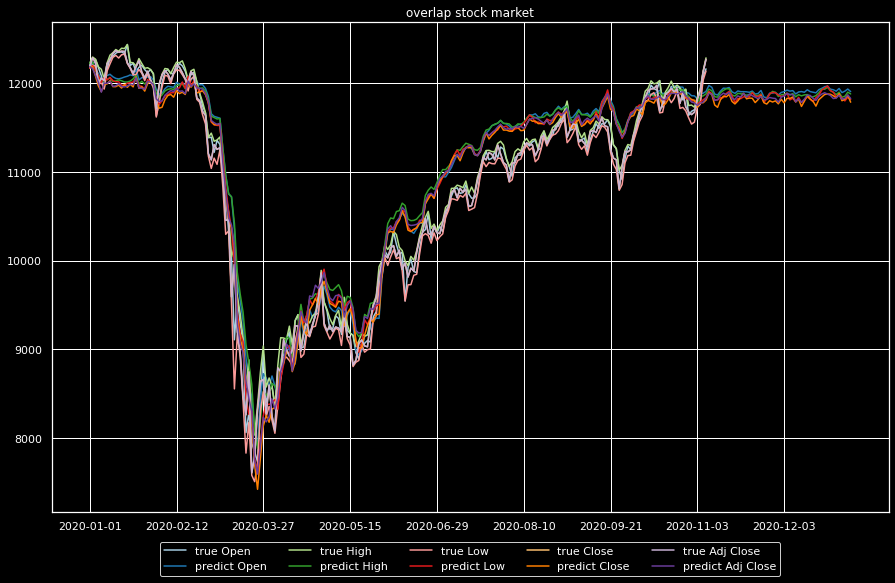

In [159]:
current_palette = sns.color_palette('Paired', 12)
fig = plt.figure(figsize = (15, 10))
ax = plt.subplot(111)
x_range_original = np.arange(df.shape[0])
x_range_future = np.arange(df_log.shape[0])
ax.plot(
    x_range_original,
    df.iloc[:, 1],
    label = 'true Open',
    color = current_palette[0],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 0], 0.5),
    label = 'predict Open',
    color = current_palette[1],
)
ax.plot(
    x_range_original,
    df.iloc[:, 2],
    label = 'true High',
    color = current_palette[2],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 1], 0.5),
    label = 'predict High',
    color = current_palette[3],
)
ax.plot(
    x_range_original,
    df.iloc[:, 3],
    label = 'true Low',
    color = current_palette[4],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 2], 0.5),
    label = 'predict Low',
    color = current_palette[5],
)
ax.plot(
    x_range_original,
    df.iloc[:, 4],
    label = 'true Close',
    color = current_palette[6],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 3], 0.5),
    label = 'predict Close',
    color = current_palette[7],
)
ax.plot(
    x_range_original,
    df.iloc[:, 5],
    label = 'true Adj Close',
    color = current_palette[8],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 4], 0.5),
    label = 'predict Adj Close',
    color = current_palette[9],
)
box = ax.get_position()
ax.set_position(
    [box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9]
)
ax.legend(
    loc = 'upper center',
    bbox_to_anchor = (0.5, -0.05),
    fancybox = True,
    shadow = True,
    ncol = 5,
)
plt.title('overlap stock market')
plt.xticks(x_range_future[::30], date_ori[::30])
plt.show()

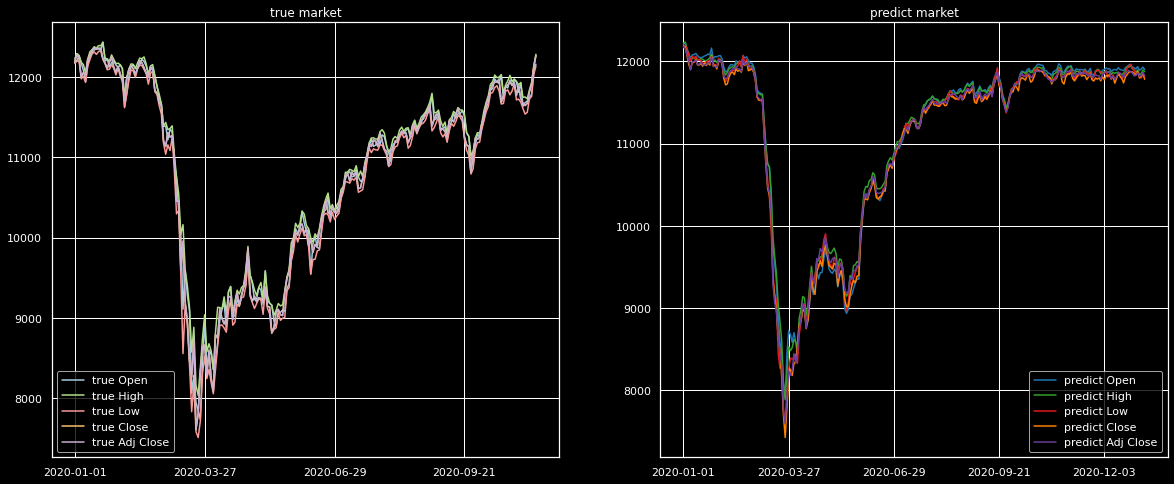

In [160]:
fig = plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
plt.plot(
    x_range_original,
    df.iloc[:, 1],
    label = 'true Open',
    color = current_palette[0],
)
plt.plot(
    x_range_original,
    df.iloc[:, 2],
    label = 'true High',
    color = current_palette[2],
)
plt.plot(
    x_range_original,
    df.iloc[:, 3],
    label = 'true Low',
    color = current_palette[4],
)
plt.plot(
    x_range_original,
    df.iloc[:, 4],
    label = 'true Close',
    color = current_palette[6],
)
plt.plot(
    x_range_original,
    df.iloc[:, 5],
    label = 'true Adj Close',
    color = current_palette[8],
)
plt.xticks(x_range_original[::60], df.iloc[:, 0].tolist()[::60])
plt.legend()
plt.title('true market')
plt.subplot(1, 2, 2)
plt.plot(
    x_range_future,
    anchor(df_log[:, 0], 0.5),
    label = 'predict Open',
    color = current_palette[1],
)
plt.plot(
    x_range_future,
    anchor(df_log[:, 1], 0.5),
    label = 'predict High',
    color = current_palette[3],
)
plt.plot(
    x_range_future,
    anchor(df_log[:, 2], 0.5),
    label = 'predict Low',
    color = current_palette[5],
)
plt.plot(
    x_range_future,
    anchor(df_log[:, 3], 0.5),
    label = 'predict Close',
    color = current_palette[7],
)
plt.plot(
    x_range_future,
    anchor(df_log[:, 4], 0.5),
    label = 'predict Adj Close',
    color = current_palette[9],
)
plt.xticks(x_range_future[::60], date_ori[::60])
plt.legend()
plt.title('predict market')
plt.show()

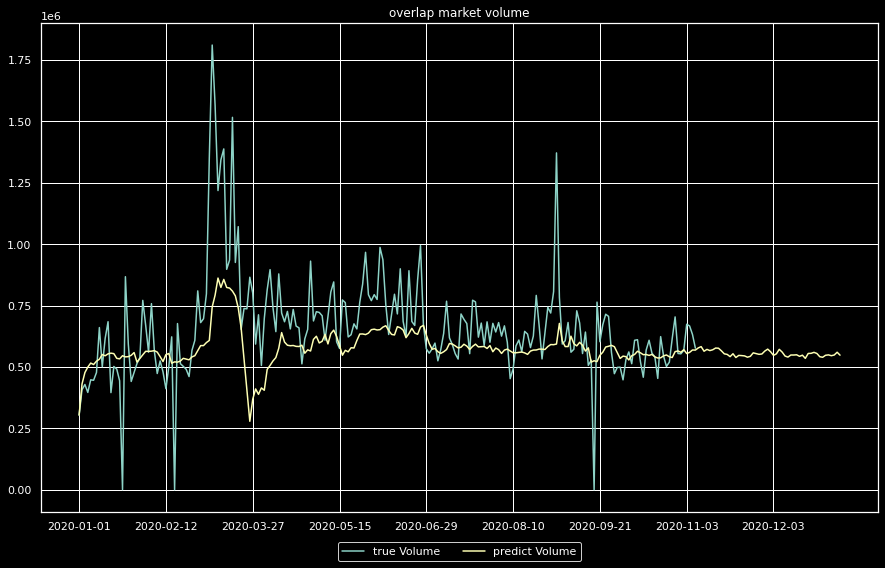

In [161]:
fig = plt.figure(figsize = (15, 10))
ax = plt.subplot(111)
ax.plot(x_range_original, df.iloc[:, -1], label = 'true Volume')
ax.plot(x_range_future, anchor(df_log[:, -1], 0.5), label = 'predict Volume')
box = ax.get_position()
ax.set_position(
    [box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9]
)
ax.legend(
    loc = 'upper center',
    bbox_to_anchor = (0.5, -0.05),
    fancybox = True,
    shadow = True,
    ncol = 5,
)
plt.xticks(x_range_future[::30], date_ori[::30])
plt.title('overlap market volume')
plt.show()

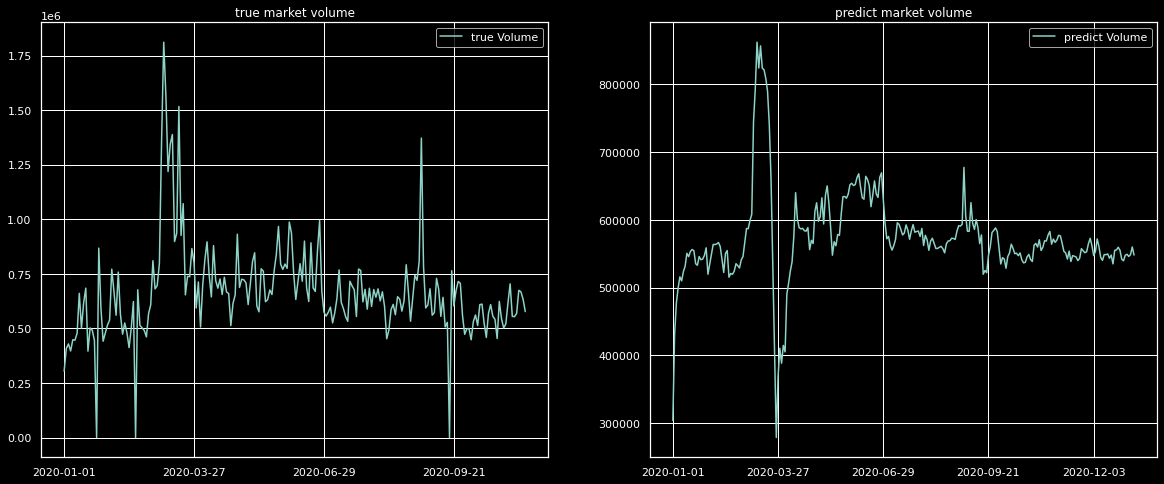

In [162]:
fig = plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
plt.plot(x_range_original, df.iloc[:, -1], label = 'true Volume')
plt.xticks(x_range_original[::60], df.iloc[:, 0].tolist()[::60])
plt.legend()
plt.title('true market volume')
plt.subplot(1, 2, 2)
plt.plot(x_range_future, anchor(df_log[:, -1], 0.5), label = 'predict Volume')
plt.xticks(x_range_future[::60], date_ori[::60])
plt.legend()
plt.title('predict market volume')
plt.show()

## GRU Recurrent Neural Network

In [163]:
df = df_full.copy()
date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
minmax = MinMaxScaler().fit(df.iloc[:, 1:].astype('float32'))
df_log = minmax.transform(df.iloc[:, 1:].astype('float32'))
df_log = pd.DataFrame(df_log)
df_log.head()

,0,1,2,3,4,5
0,0.951367,0.952590,0.967549,0.962164,0.962164,0.167918
1,0.950600,0.967999,0.973775,0.983144,0.983144,0.225124
2,0.963922,0.962468,0.972964,0.971455,0.971455,0.236775
3,0.944647,0.942780,0.927822,0.922297,0.922297,0.218940
4,0.925160,0.936646,0.934297,0.934902,0.934902,0.247267


In [164]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.GRUCell(size_layer)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        rnn_W = tf.Variable(tf.random_normal((size_layer, output_size)))
        rnn_B = tf.Variable(tf.random_normal([output_size]))
        self.logits = tf.matmul(self.outputs[-1], rnn_W) + rnn_B
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [165]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 200
dropout_rate = 0.9
future_day = 50

In [166]:
tf.reset_default_graph()
modelnn = Model(
    0.01, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [167]:
for i in range(epoch):
    init_value = np.zeros((1, num_layers * size_layer))
    total_loss = 0
    for k in range(0, df_log.shape[0] - 1, timestamp):
        index = min(k + timestamp, df_log.shape[0] - 1)
        batch_x = np.expand_dims(df_log.iloc[k:index, :].values, axis = 0)
        batch_y = df_log.iloc[k + 1 : index + 1, :].values
        last_state, _, loss = sess.run(
            [modelnn.last_state, modelnn.optimizer, modelnn.cost],
            feed_dict = {
                modelnn.X: batch_x,
                modelnn.Y: batch_y,
                modelnn.hidden_layer: init_value,
            },
        )
        loss = np.mean(loss)
        init_value = last_state
        total_loss += loss
    total_loss /= df_log.shape[0] // timestamp
    if (i + 1) % 100 == 0:
        print('epoch:', i + 1, 'avg loss:', total_loss)

epoch: 100 avg loss: 0.011254044565638261
epoch: 200 avg loss: 0.0047082330649053416


In [168]:
output_predict = np.zeros((df_log.shape[0] + future_day, df_log.shape[1]))
output_predict[0, :] = df_log.iloc[0, :]
upper_b = (df_log.shape[0] // timestamp) * timestamp
init_value = np.zeros((1, num_layers * size_layer))
for k in range(0, (df_log.shape[0] // timestamp) * timestamp, timestamp):
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(
                df_log.iloc[k : k + timestamp, :], axis = 0
            ),
            modelnn.hidden_layer: init_value,
        },
    )
    init_value = last_state
    output_predict[k + 1 : k + timestamp + 1, :] = out_logits

out_logits, last_state = sess.run(
    [modelnn.logits, modelnn.last_state],
    feed_dict = {
        modelnn.X: np.expand_dims(df_log.iloc[upper_b:, :], axis = 0),
        modelnn.hidden_layer: init_value,
    },
)
init_value = last_state
output_predict[upper_b + 1 : df_log.shape[0] + 1, :] = out_logits
df_log.loc[df_log.shape[0]] = out_logits[-1, :]
date_ori.append(date_ori[-1] + timedelta(days = 1))


In [169]:
for i in range(future_day - 1):
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(df_log.iloc[-timestamp:, :], axis = 0),
            modelnn.hidden_layer: init_value,
        },
    )
    init_value = last_state
    output_predict[df_log.shape[0], :] = out_logits[-1, :]
    df_log.loc[df_log.shape[0]] = out_logits[-1, :]
    date_ori.append(date_ori[-1] + timedelta(days = 1))


In [170]:
df_log = minmax.inverse_transform(output_predict)
date_ori = pd.Series(date_ori).dt.strftime(date_format = '%Y-%m-%d').tolist()

In [171]:
def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

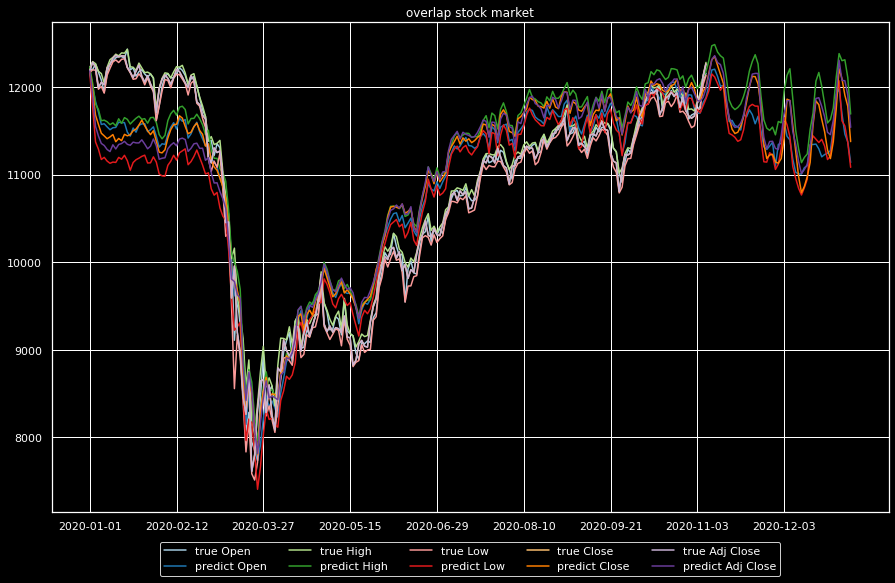

In [172]:
current_palette = sns.color_palette('Paired', 12)
fig = plt.figure(figsize = (15, 10))
ax = plt.subplot(111)
x_range_original = np.arange(df.shape[0])
x_range_future = np.arange(df_log.shape[0])
ax.plot(
    x_range_original,
    df.iloc[:, 1],
    label = 'true Open',
    color = current_palette[0],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 0], 0.5),
    label = 'predict Open',
    color = current_palette[1],
)
ax.plot(
    x_range_original,
    df.iloc[:, 2],
    label = 'true High',
    color = current_palette[2],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 1], 0.5),
    label = 'predict High',
    color = current_palette[3],
)
ax.plot(
    x_range_original,
    df.iloc[:, 3],
    label = 'true Low',
    color = current_palette[4],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 2], 0.5),
    label = 'predict Low',
    color = current_palette[5],
)
ax.plot(
    x_range_original,
    df.iloc[:, 4],
    label = 'true Close',
    color = current_palette[6],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 3], 0.5),
    label = 'predict Close',
    color = current_palette[7],
)
ax.plot(
    x_range_original,
    df.iloc[:, 5],
    label = 'true Adj Close',
    color = current_palette[8],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 4], 0.5),
    label = 'predict Adj Close',
    color = current_palette[9],
)
box = ax.get_position()
ax.set_position(
    [box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9]
)
ax.legend(
    loc = 'upper center',
    bbox_to_anchor = (0.5, -0.05),
    fancybox = True,
    shadow = True,
    ncol = 5,
)
plt.title('overlap stock market')
plt.xticks(x_range_future[::30], date_ori[::30])
plt.show()

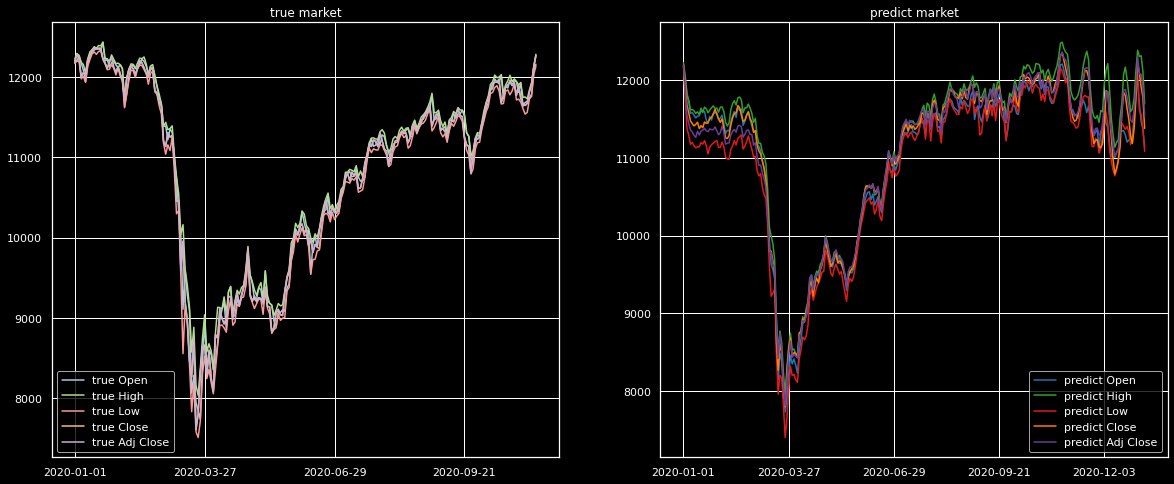

In [173]:
fig = plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
plt.plot(
    x_range_original,
    df.iloc[:, 1],
    label = 'true Open',
    color = current_palette[0],
)
plt.plot(
    x_range_original,
    df.iloc[:, 2],
    label = 'true High',
    color = current_palette[2],
)
plt.plot(
    x_range_original,
    df.iloc[:, 3],
    label = 'true Low',
    color = current_palette[4],
)
plt.plot(
    x_range_original,
    df.iloc[:, 4],
    label = 'true Close',
    color = current_palette[6],
)
plt.plot(
    x_range_original,
    df.iloc[:, 5],
    label = 'true Adj Close',
    color = current_palette[8],
)
plt.xticks(x_range_original[::60], df.iloc[:, 0].tolist()[::60])
plt.legend()
plt.title('true market')
plt.subplot(1, 2, 2)
plt.plot(
    x_range_future,
    anchor(df_log[:, 0], 0.5),
    label = 'predict Open',
    color = current_palette[1],
)
plt.plot(
    x_range_future,
    anchor(df_log[:, 1], 0.5),
    label = 'predict High',
    color = current_palette[3],
)
plt.plot(
    x_range_future,
    anchor(df_log[:, 2], 0.5),
    label = 'predict Low',
    color = current_palette[5],
)
plt.plot(
    x_range_future,
    anchor(df_log[:, 3], 0.5),
    label = 'predict Close',
    color = current_palette[7],
)
plt.plot(
    x_range_future,
    anchor(df_log[:, 4], 0.5),
    label = 'predict Adj Close',
    color = current_palette[9],
)
plt.xticks(x_range_future[::60], date_ori[::60])
plt.legend()
plt.title('predict market')
plt.show()

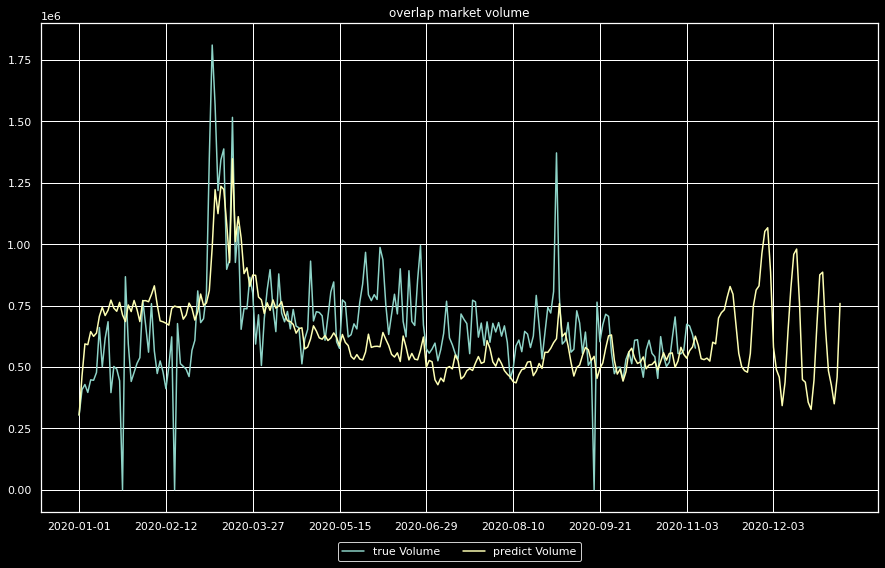

In [174]:
fig = plt.figure(figsize = (15, 10))
ax = plt.subplot(111)
ax.plot(x_range_original, df.iloc[:, -1], label = 'true Volume')
ax.plot(x_range_future, anchor(df_log[:, -1], 0.5), label = 'predict Volume')
box = ax.get_position()
ax.set_position(
    [box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9]
)
ax.legend(
    loc = 'upper center',
    bbox_to_anchor = (0.5, -0.05),
    fancybox = True,
    shadow = True,
    ncol = 5,
)
plt.xticks(x_range_future[::30], date_ori[::30])
plt.title('overlap market volume')
plt.show()

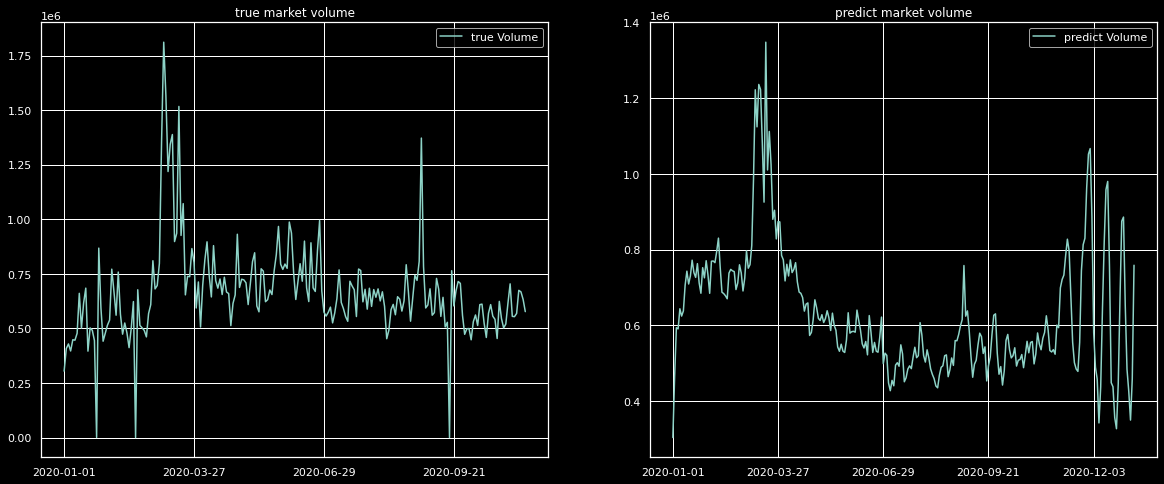

In [175]:
fig = plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
plt.plot(x_range_original, df.iloc[:, -1], label = 'true Volume')
plt.xticks(x_range_original[::60], df.iloc[:, 0].tolist()[::60])
plt.legend()
plt.title('true market volume')
plt.subplot(1, 2, 2)
plt.plot(x_range_future, anchor(df_log[:, -1], 0.5), label = 'predict Volume')
plt.xticks(x_range_future[::60], date_ori[::60])
plt.legend()
plt.title('predict market volume')
plt.show()

## Encoder-Decoder Feed-forward + GRU Recurrent Neural Network

In [176]:
df = df_full.copy()
date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
minmax = MinMaxScaler().fit(df.iloc[:, 1:].astype('float32'))
df_log = minmax.transform(df.iloc[:, 1:].astype('float32'))
df_log = pd.DataFrame(df_log)
df_log.head()

,0,1,2,3,4,5
0,0.951367,0.952590,0.967549,0.962164,0.962164,0.167918
1,0.950600,0.967999,0.973775,0.983144,0.983144,0.225124
2,0.963922,0.962468,0.972964,0.971455,0.971455,0.236775
3,0.944647,0.942780,0.927822,0.922297,0.922297,0.218940
4,0.925160,0.936646,0.934297,0.934902,0.934902,0.247267


In [177]:
def reducedimension(
    input_, dimension = 2, learning_rate = 0.01, hidden_layer = 256, epoch = 20
):

    input_size = input_.shape[1]
    X = tf.placeholder('float', [None, input_size])
    first_layer_encoder = tf.layers.dense(
        X, hidden_layer, activation = tf.nn.sigmoid
    )
    second_layer_encoder = tf.layers.dense(
        first_layer_encoder, dimension, activation = tf.nn.sigmoid
    )
    first_layer_decoder = tf.layers.dense(
        second_layer_encoder, hidden_layer, activation = tf.nn.sigmoid
    )
    second_layer_decoder = tf.layers.dense(
        first_layer_decoder, input_size, activation = tf.nn.sigmoid
    )
    cost = tf.reduce_mean(tf.square(X - second_layer_decoder))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())

    for i in range(epoch):
        last_time = time.time()
        _, loss = sess.run([optimizer, cost], feed_dict = {X: input_})
        if (i + 1) % 10 == 0:
            print(
                'epoch:', i + 1, 'loss:', loss, 'time:', time.time() - last_time
            )

    vectors = sess.run(second_layer_encoder, feed_dict = {X: input_})
    tf.reset_default_graph()
    return vectors

In [178]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.GRUCell(size_layer)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

You can try to reduce dimensions if you more features like sentiment value, sentiment spike and etc

In [179]:
thought_vector = reducedimension(
    df_log.values,
    dimension = 16,
    learning_rate = 0.001,
    hidden_layer = 128,
    epoch = 100,
)

epoch: 10 loss: 0.11506965 time: 0.0014650821685791016
epoch: 20 loss: 0.114662305 time: 0.0014944076538085938
epoch: 30 loss: 0.11425622 time: 0.0019266605377197266
epoch: 40 loss: 0.11385146 time: 0.0015037059783935547
epoch: 50 loss: 0.11344798 time: 0.0014960765838623047
epoch: 60 loss: 0.11304578 time: 0.001550436019897461
epoch: 70 loss: 0.11264485 time: 0.0015740394592285156
epoch: 80 loss: 0.112245195 time: 0.0016224384307861328
epoch: 90 loss: 0.11184683 time: 0.0014729499816894531
epoch: 100 loss: 0.111449756 time: 0.0015437602996826172


In [180]:
thought_vector.shape

(214, 16)

In [181]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 500
dropout_rate = 0.1

In [182]:
tf.reset_default_graph()
modelnn = Model(0.001, num_layers, thought_vector.shape[1], size_layer, df_log.shape[1], dropout_rate)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [183]:
for i in range(epoch):
    init_value = np.zeros((1, num_layers * size_layer))
    total_loss = 0
    for k in range(0, df_log.shape[0] - 1, timestamp):
        index = min(k + timestamp, df_log.shape[0] - 1)
        batch_x = np.expand_dims(thought_vector[k:index], axis = 0)
        batch_y = df_log.iloc[k + 1 : index + 1].values
        last_state, _, loss = sess.run(
            [modelnn.last_state, modelnn.optimizer, modelnn.cost],
            feed_dict = {
                modelnn.X: batch_x,
                modelnn.Y: batch_y,
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        total_loss += loss
    total_loss /= df_log.shape[0] // timestamp
    if (i + 1) % 100 == 0:
        print('epoch:', i + 1, 'avg loss:', total_loss)

epoch: 100 avg loss: 0.0614933369160142
epoch: 200 avg loss: 0.06436985540425494
epoch: 300 avg loss: 0.061144565067176394
epoch: 400 avg loss: 0.06276344757671246
epoch: 500 avg loss: 0.06150637311206776


In [185]:
output_predict = np.zeros((df_log.shape[0] + 1, df_log.shape[1]))
output_predict[0] = df_log.iloc[0]
upper_b = (df_log.shape[0] // timestamp) * timestamp
init_value = np.zeros((1, num_layers * size_layer))
for k in range(0, (df_log.shape[0] // timestamp) * timestamp, timestamp):
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(
                thought_vector[k : k + timestamp], axis = 0
            ),
            modelnn.hidden_layer: init_value,
        },
    )
    init_value = last_state
    output_predict[k + 1 : k + timestamp + 1] = out_logits

out_logits, last_state = sess.run(
    [modelnn.logits, modelnn.last_state],
    feed_dict = {
        modelnn.X: np.expand_dims(thought_vector[upper_b:], axis = 0),
        modelnn.hidden_layer: init_value,
    },
)
init_value = last_state
output_predict[upper_b + 1 : df_log.shape[0] + 1] = out_logits
df_log.loc[df_log.shape[0]] = out_logits[-1]
date_ori.append(date_ori[-1] + timedelta(days = 1))

In [186]:
df_log = minmax.inverse_transform(output_predict)
date_ori = pd.Series(date_ori).dt.strftime(date_format = '%Y-%m-%d').tolist()

In [187]:
def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

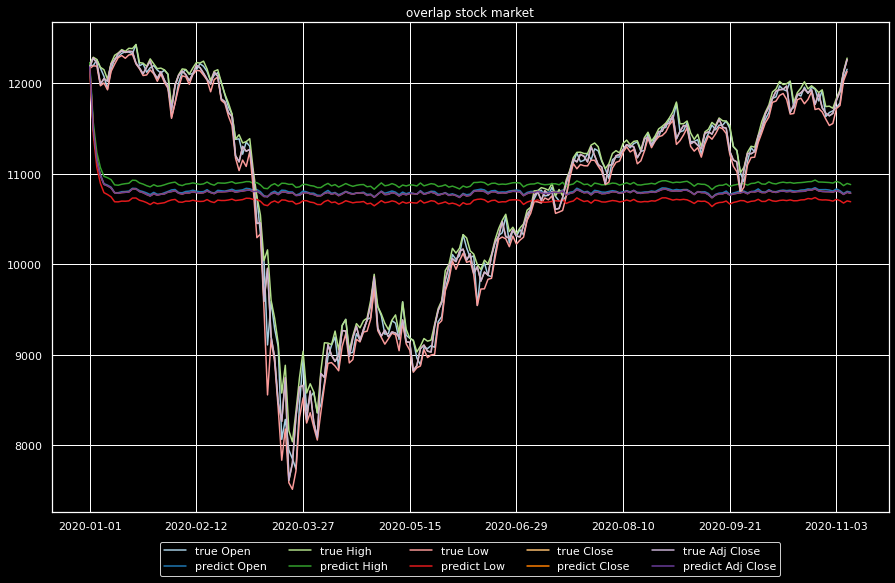

In [188]:
current_palette = sns.color_palette('Paired', 12)
fig = plt.figure(figsize = (15, 10))
ax = plt.subplot(111)
x_range_original = np.arange(df.shape[0])
x_range_future = np.arange(df_log.shape[0])
ax.plot(
    x_range_original,
    df.iloc[:, 1],
    label = 'true Open',
    color = current_palette[0],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 0], 0.5),
    label = 'predict Open',
    color = current_palette[1],
)
ax.plot(
    x_range_original,
    df.iloc[:, 2],
    label = 'true High',
    color = current_palette[2],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 1], 0.5),
    label = 'predict High',
    color = current_palette[3],
)
ax.plot(
    x_range_original,
    df.iloc[:, 3],
    label = 'true Low',
    color = current_palette[4],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 2], 0.5),
    label = 'predict Low',
    color = current_palette[5],
)
ax.plot(
    x_range_original,
    df.iloc[:, 4],
    label = 'true Close',
    color = current_palette[6],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 3], 0.5),
    label = 'predict Close',
    color = current_palette[7],
)
ax.plot(
    x_range_original,
    df.iloc[:, 5],
    label = 'true Adj Close',
    color = current_palette[8],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 4], 0.5),
    label = 'predict Adj Close',
    color = current_palette[9],
)
box = ax.get_position()
ax.set_position(
    [box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9]
)
ax.legend(
    loc = 'upper center',
    bbox_to_anchor = (0.5, -0.05),
    fancybox = True,
    shadow = True,
    ncol = 5,
)
plt.title('overlap stock market')
plt.xticks(x_range_future[::30], date_ori[::30])
plt.show()

## GRU Bidirectional Neural Network

In [189]:
df = df_full.copy()
date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
minmax = MinMaxScaler().fit(df.iloc[:, 1:].astype('float32'))
df_log = minmax.transform(df.iloc[:, 1:].astype('float32'))
df_log = pd.DataFrame(df_log)
df_log.head()

,0,1,2,3,4,5
0,0.951367,0.952590,0.967549,0.962164,0.962164,0.167918
1,0.950600,0.967999,0.973775,0.983144,0.983144,0.225124
2,0.963922,0.962468,0.972964,0.971455,0.971455,0.236775
3,0.944647,0.942780,0.927822,0.922297,0.922297,0.218940
4,0.925160,0.936646,0.934297,0.934902,0.934902,0.247267


In [190]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.GRUCell(size_layer)

        backward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        forward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop_backward = tf.contrib.rnn.DropoutWrapper(
            backward_rnn_cells, output_keep_prob = forget_bias
        )
        forward_backward = tf.contrib.rnn.DropoutWrapper(
            forward_rnn_cells, output_keep_prob = forget_bias
        )
        self.backward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * size_layer)
        )
        self.forward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * size_layer)
        )
        self.outputs, self.last_state = tf.nn.bidirectional_dynamic_rnn(
            forward_backward,
            drop_backward,
            self.X,
            initial_state_fw = self.forward_hidden_layer,
            initial_state_bw = self.backward_hidden_layer,
            dtype = tf.float32,
        )
        self.outputs = tf.concat(self.outputs, 2)
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [191]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 200
dropout_rate = 0.9
future_day = 50

In [192]:
tf.reset_default_graph()
modelnn = Model(0.01, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [193]:
for i in range(epoch):
    init_value_forward = np.zeros((1, num_layers * size_layer))
    init_value_backward = np.zeros((1, num_layers * size_layer))
    total_loss = 0
    for k in range(0, df_log.shape[0] - 1, timestamp):
        index = min(k + timestamp, df_log.shape[0] - 1)
        batch_x = np.expand_dims(df_log.iloc[k:index].values, axis = 0)
        batch_y = df_log.iloc[k + 1 : index + 1].values
        last_state, _, loss = sess.run(
            [modelnn.last_state, modelnn.optimizer, modelnn.cost],
            feed_dict = {
                modelnn.X: batch_x,
                modelnn.Y: batch_y,
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        total_loss += loss
    total_loss /= df_log.shape[0] // timestamp
    if (i + 1) % 100 == 0:
        print('epoch:', i + 1, 'avg loss:', total_loss)

epoch: 100 avg loss: 0.019046104867898282
epoch: 200 avg loss: 0.004027211703249209


In [194]:
output_predict = np.zeros((df_log.shape[0] + future_day, df_log.shape[1]))
output_predict[0] = df_log.iloc[0]
upper_b = (df_log.shape[0] // timestamp) * timestamp
init_value_forward = np.zeros((1, num_layers * size_layer))
init_value_backward = np.zeros((1, num_layers * size_layer))
for k in range(0, (df_log.shape[0] // timestamp) * timestamp, timestamp):
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(df_log.iloc[k : k + timestamp], axis = 0),
            modelnn.backward_hidden_layer: init_value_backward,
            modelnn.forward_hidden_layer: init_value_forward,
        },
    )
    init_value_forward = last_state[0]
    init_value_backward = last_state[1]
    output_predict[k + 1 : k + timestamp + 1] = out_logits

out_logits, last_state = sess.run(
    [modelnn.logits, modelnn.last_state],
    feed_dict = {
        modelnn.X: np.expand_dims(df_log.iloc[upper_b:], axis = 0),
        modelnn.backward_hidden_layer: init_value_backward,
        modelnn.forward_hidden_layer: init_value_forward,
    },
)
init_value_forward = last_state[0]
init_value_backward = last_state[1]
output_predict[upper_b + 1 : df_log.shape[0] + 1] = out_logits
df_log.loc[df_log.shape[0]] = out_logits[-1]
date_ori.append(date_ori[-1] + timedelta(days = 1))

In [195]:
for i in range(future_day - 1):
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(df_log.iloc[-timestamp:], axis = 0),
            modelnn.backward_hidden_layer: init_value_backward,
            modelnn.forward_hidden_layer: init_value_forward,
        },
    )
    init_value_forward = last_state[0]
    init_value_backward = last_state[1]
    output_predict[df_log.shape[0]] = out_logits[-1]
    df_log.loc[df_log.shape[0]] = out_logits[-1]
    date_ori.append(date_ori[-1] + timedelta(days = 1))

In [196]:
df_log = minmax.inverse_transform(output_predict)
date_ori = pd.Series(date_ori).dt.strftime(date_format = '%Y-%m-%d').tolist()

In [197]:
def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

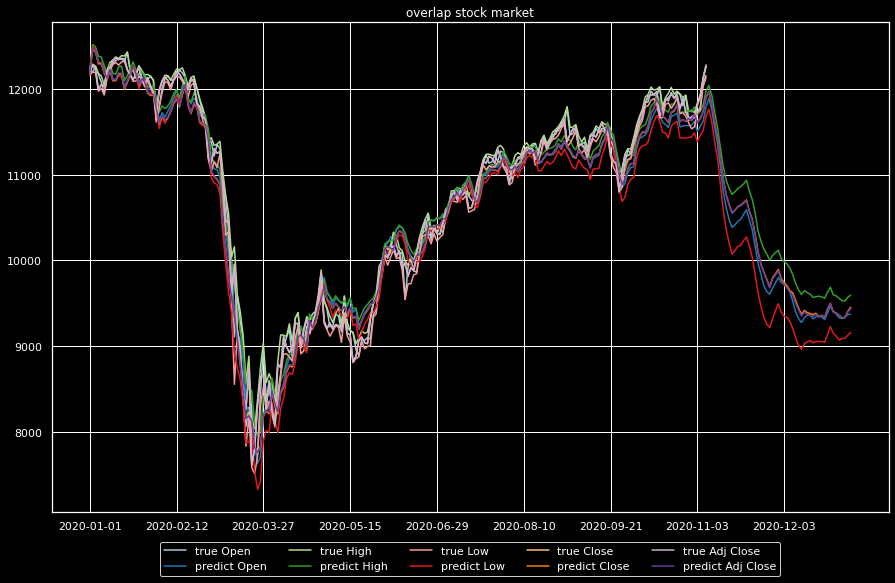

In [198]:
current_palette = sns.color_palette('Paired', 12)
fig = plt.figure(figsize = (15, 10))
ax = plt.subplot(111)
x_range_original = np.arange(df.shape[0])
x_range_future = np.arange(df_log.shape[0])
ax.plot(
    x_range_original,
    df.iloc[:, 1],
    label = 'true Open',
    color = current_palette[0],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 0], 0.5),
    label = 'predict Open',
    color = current_palette[1],
)
ax.plot(
    x_range_original,
    df.iloc[:, 2],
    label = 'true High',
    color = current_palette[2],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 1], 0.5),
    label = 'predict High',
    color = current_palette[3],
)
ax.plot(
    x_range_original,
    df.iloc[:, 3],
    label = 'true Low',
    color = current_palette[4],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 2], 0.5),
    label = 'predict Low',
    color = current_palette[5],
)
ax.plot(
    x_range_original,
    df.iloc[:, 4],
    label = 'true Close',
    color = current_palette[6],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 3], 0.5),
    label = 'predict Close',
    color = current_palette[7],
)
ax.plot(
    x_range_original,
    df.iloc[:, 5],
    label = 'true Adj Close',
    color = current_palette[8],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 4], 0.5),
    label = 'predict Adj Close',
    color = current_palette[9],
)
box = ax.get_position()
ax.set_position(
    [box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9]
)
ax.legend(
    loc = 'upper center',
    bbox_to_anchor = (0.5, -0.05),
    fancybox = True,
    shadow = True,
    ncol = 5,
)
plt.title('overlap stock market')
plt.xticks(x_range_future[::30], date_ori[::30])
plt.show()

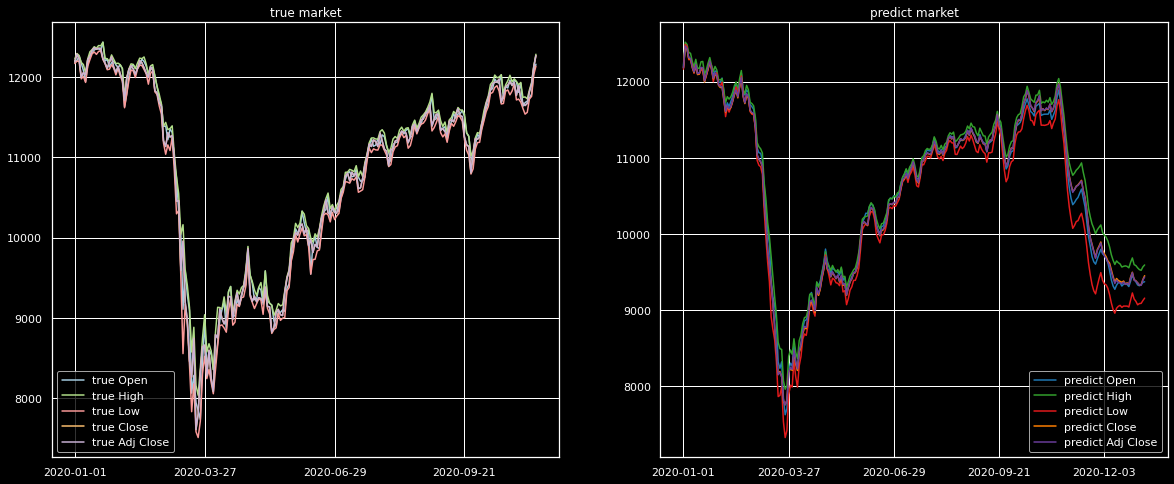

In [199]:
fig = plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
plt.plot(
    x_range_original,
    df.iloc[:, 1],
    label = 'true Open',
    color = current_palette[0],
)
plt.plot(
    x_range_original,
    df.iloc[:, 2],
    label = 'true High',
    color = current_palette[2],
)
plt.plot(
    x_range_original,
    df.iloc[:, 3],
    label = 'true Low',
    color = current_palette[4],
)
plt.plot(
    x_range_original,
    df.iloc[:, 4],
    label = 'true Close',
    color = current_palette[6],
)
plt.plot(
    x_range_original,
    df.iloc[:, 5],
    label = 'true Adj Close',
    color = current_palette[8],
)
plt.xticks(x_range_original[::60], df.iloc[:, 0].tolist()[::60])
plt.legend()
plt.title('true market')
plt.subplot(1, 2, 2)
plt.plot(
    x_range_future,
    anchor(df_log[:, 0], 0.5),
    label = 'predict Open',
    color = current_palette[1],
)
plt.plot(
    x_range_future,
    anchor(df_log[:, 1], 0.5),
    label = 'predict High',
    color = current_palette[3],
)
plt.plot(
    x_range_future,
    anchor(df_log[:, 2], 0.5),
    label = 'predict Low',
    color = current_palette[5],
)
plt.plot(
    x_range_future,
    anchor(df_log[:, 3], 0.5),
    label = 'predict Close',
    color = current_palette[7],
)
plt.plot(
    x_range_future,
    anchor(df_log[:, 4], 0.5),
    label = 'predict Adj Close',
    color = current_palette[9],
)
plt.xticks(x_range_future[::60], date_ori[::60])
plt.legend()
plt.title('predict market')
plt.show()

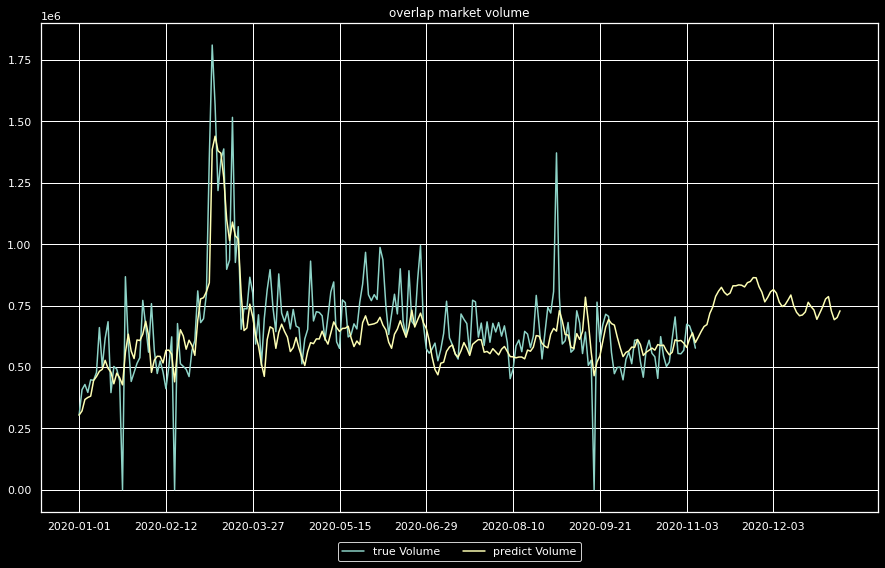

In [200]:
fig = plt.figure(figsize = (15, 10))
ax = plt.subplot(111)
ax.plot(x_range_original, df.iloc[:, -1], label = 'true Volume')
ax.plot(x_range_future, anchor(df_log[:, -1], 0.5), label = 'predict Volume')
box = ax.get_position()
ax.set_position(
    [box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9]
)
ax.legend(
    loc = 'upper center',
    bbox_to_anchor = (0.5, -0.05),
    fancybox = True,
    shadow = True,
    ncol = 5,
)
plt.xticks(x_range_future[::30], date_ori[::30])
plt.title('overlap market volume')
plt.show()

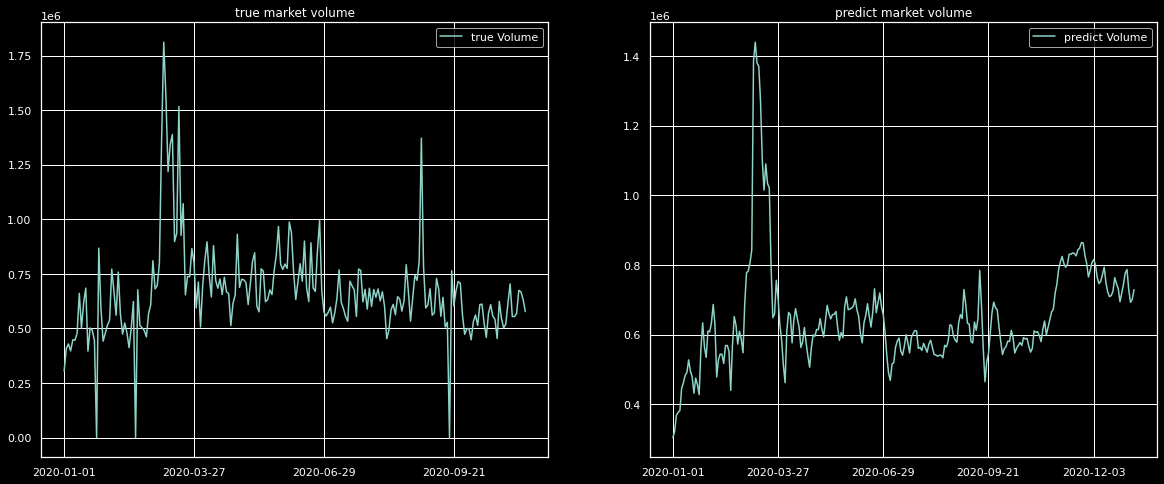

In [201]:
fig = plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
plt.plot(x_range_original, df.iloc[:, -1], label = 'true Volume')
plt.xticks(x_range_original[::60], df.iloc[:, 0].tolist()[::60])
plt.legend()
plt.title('true market volume')
plt.subplot(1, 2, 2)
plt.plot(x_range_future, anchor(df_log[:, -1], 0.5), label = 'predict Volume')
plt.xticks(x_range_future[::60], date_ori[::60])
plt.legend()
plt.title('predict market volume')
plt.show()